In [1]:
date_list = {2014:{"Merced":[date(2014, 3, 24), 
                            date(2014, 4, 6), 
                             date(2014, 4, 14), 
                             date(2014, 4, 23), 
                             date(2014, 4, 29), 
                             date(2014, 5, 3), 
                             date(2014, 5, 12)], 
                  "Tuolumne": [date(2014, 3, 23), 
                             date(2014, 4, 7), 
                             date(2014, 4, 13), 
                             date(2014, 4, 20), 
                             date(2014, 4, 28), 
                             date(2014, 5, 2), 
                             date(2014, 5, 11)]},
             2016: {"Tuolumne": [date(2016, 4, 1), 
                                 date(2016, 4, 7),
                                 date(2016, 4, 16),
                                 date(2016, 4, 26),
                                 date(2016, 5, 27),
                                 date(2016, 6, 7), 
                                 date(2016, 6, 13),
                                 date(2016, 6, 20)]}}

### Initiate the modules needed for GMM_clustering, dbTools and rasterTools

In [2]:
from rasterTools import rasterTools
from dbTools import dbTools
from datetime import datetime, date
from GMM_clustering import GMM_clustering
import os
import warnings
warnings.filterwarnings("ignore")
db = dbTools('knn_project', 'zeshi')

In [ ]:
GMM_cluster = GMM_clustering("Tuolumne", db, 30, 35, cv_types=['full'])
GMM_cluster.GMM_number(n_iter=5000)
GMM_cluster.GMM_bic_scores()
GMM_cluster.GMM_loc()
GMM_cluster.GMM_loc_map()

In [ ]:
pickle.dump(GMM_cluster.sensor_idx, open('kNN_training_testing/tb_sensor_idx.p', 'wb'))

### Initiate the modules needed for kNN_swe_regressor

In [3]:
from kNN_swe_regressor import kNN_swe_regressor
import pickle
tb_sensor_idx = pickle.load(open('kNN_training_testing/tb_sensor_idx.p', 'rb'))
tb_knn_swe_regressor_2014 = kNN_swe_regressor('Tuolumne', 2014, date_list, 30)
tb_knn_swe_regressor_2014.kNN_feature_construct(tb_sensor_idx)
tb_knn_swe_regressor_2014.load_kNN_data()
tb_knn_swe_regressor_2014.kNN_predict()
# tb_knn_swe_regressor_2014.kNN_recon_snodas_vs_lidar()

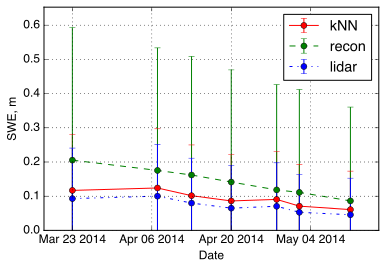

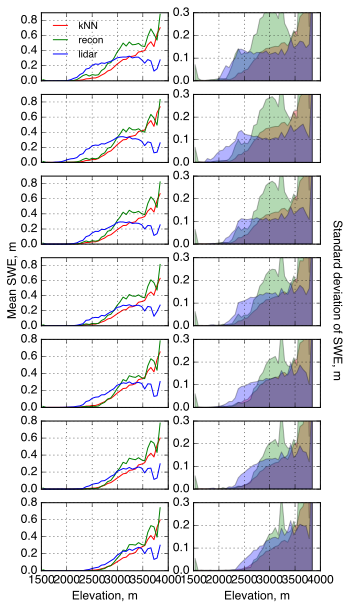

In [4]:
tb_knn_swe_regressor_2014.kNN_update_est_stats()
tb_knn_swe_regressor_2014.kNN_update_mean_std()
tb_knn_swe_regressor_2014.kNN_mean_std_ts()
tb_knn_swe_regressor_2014.elev_band_mean_std_comparison()

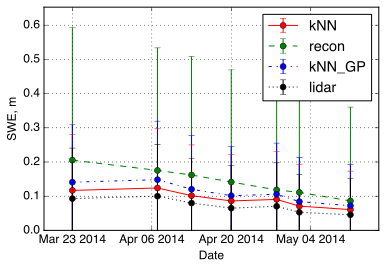

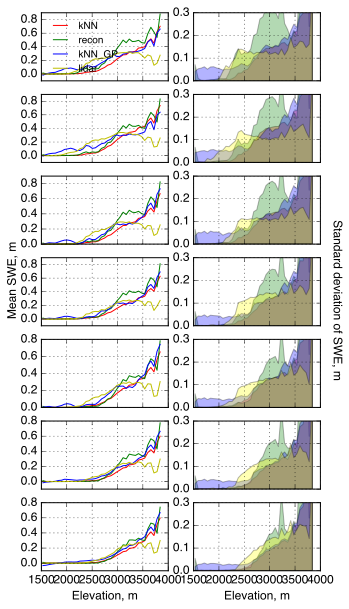

In [5]:
from GP_swe_regressor import GP_swe_regressor
tb_gp_regressor = GP_swe_regressor(db, 'Tuolumne', None)
tb_gp_regressor.update_kNN(tb_knn_swe_regressor_2014)
tb_knn_swe_regressor_2014.kNN_mean_std_ts()
tb_knn_swe_regressor_2014.elev_band_mean_std_comparison()

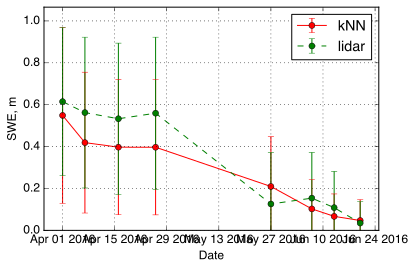

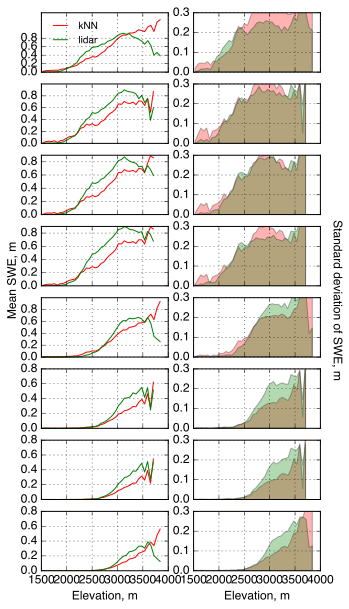

In [5]:
from kNN_swe_regressor import kNN_swe_regressor
import pickle
tb_sensor_idx = pickle.load(open('kNN_training_testing/tb_sensor_idx.p', 'rb'))
tb_knn_swe_regressor_2016 = kNN_swe_regressor('Tuolumne', 2016, date_list, 30)
tb_knn_swe_regressor_2016.kNN_feature_construct(tb_sensor_idx)
tb_knn_swe_regressor_2016.load_kNN_data()
tb_knn_swe_regressor_2016.kNN_predict()
tb_knn_swe_regressor_2016.kNN_update_est_stats()
tb_knn_swe_regressor_2016.kNN_update_mean_std()
tb_knn_swe_regressor_2016.kNN_mean_std_ts()
tb_knn_swe_regressor_2016.elev_band_mean_std_comparison()

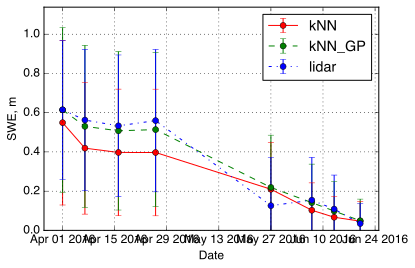

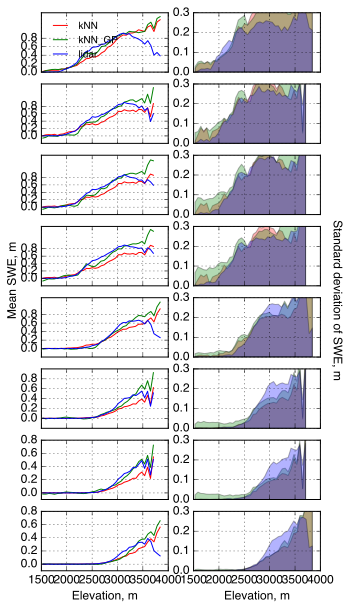

In [6]:
from GP_swe_regressor import GP_swe_regressor
tb_gp_regressor = GP_swe_regressor(db, 'Tuolumne', None)
tb_gp_regressor.update_kNN(tb_knn_swe_regressor_2016)
tb_knn_swe_regressor_2016.kNN_mean_std_ts()
tb_knn_swe_regressor_2016.elev_band_mean_std_comparison()

In [ ]:
elev_cut = None
"""
input: elev_cut, int
output: class_image, 2D array the same shape as DEM, showing the classes of each pixel belongs to
        sensor_idx, sensor's [row, col] indices on the map
"""
from sklearn.neighbors import KDTree
GMM_feature = db.load_features(sensor=False, exclude_null=False, basin="Tuolumne")
dem = db.db.query_map("DEM", "topo", "Tuolumne")
dem[dem < 0.] = np.nan
ygrid, xgrid = np.meshgrid(range(dem.shape[0]), range(dem.shape[1]), sparse=False, indexing='ij')
print xgrid, ygrid
if elev_cut is not None:
    print "Enforce more sampling"
    GMM_feature_idx = np.where(np.logical_and(np.isfinite(GMM_feature[:, 2]), 
                                                          GMM_feature[:, 2] >= elev_cut))
else:
    GMM_feature_idx = np.where(np.isfinite(GMM_feature[:, 2]))

# Extract finite feature space
GMM_feature_finite = GMM_feature[GMM_feature_idx]
X = GMM_feature_finite

# Initialize class image for entire map space, including nans
class_image = np.zeros(len(GMM_feature))
class_image[np.isnan(GMM_feature[:, 2])] = np.nan

# fit and predict GMM classification
labels = GMM_cluster.clf.predict(X)

# Labeling the class to the finite/valid features
class_image[GMM_feature_idx] = labels
class_image = np.reshape(class_image, dem.shape)

# Loop through labels to get the centroid of each cluster and find the nearest neighbor in 2D space
unique_labels = np.unique(labels)
x_idx_list = []
y_idx_list = []
for label in unique_labels:
#     print label
    temp_labels_idx = np.where(labels==label)
    X_label = X[labels==label, 2:]
    X_label_KDTree = KDTree(X_label)
    X_label_median = np.nanmean(X_label, axis=0)
    dist, idx = X_label_KDTree.query(np.array([X_label_median]))
    X_label_median_idx = temp_labels_idx[0][idx]
    GMM_feature_median_label_idx = GMM_feature_idx[0][X_label_median_idx]
    x_idx = xgrid.flatten()[GMM_feature_median_label_idx]
    y_idx = ygrid.flatten()[GMM_feature_median_label_idx]
    x_idx_list.append(x_idx[0][0])
    y_idx_list.append(y_idx[0][0])
sensor_idx = (np.array(y_idx_list), np.array(x_idx_list))
print sensor_idx

fig, ax = plt.subplots(figsize=(3.5, 3.5))

# Load basin
dem = db.db.query_map('DEM', 'topo',"Tuolumne")
dem_show = np.copy(dem)
dem_show[dem_show <= 0.] = np.nan
im = ax.imshow(dem_show, cmap='terrain', interpolation='bilinear')
x_idx_list = sensor_idx[1]
y_idx_list = sensor_idx[0]
x_idx_list_show = np.array(x_idx_list) + 0.5
y_idx_list_show = np.array(y_idx_list) + 0.5
plt.plot(x_idx_list_show, y_idx_list_show, '.k', markersize=10)
plt.xlim([0, dem.shape[1]])
plt.ylim([dem.shape[0], 0])
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax, ticks=[1200, 2000, 2800, 3600], orientation='horizontal')
cb.outline.set_visible(False)
plt.subplots_adjust(hspace=0)
plt.savefig("selected_location_" + self.site_name.lower() + ".pdf", dpi=1000, bbox_inch="tight")

preprocessing the data, convert all historical reconstruction data into the same shape as 500-m Lidar data

The idea here is to find representative 20-ish pixels of the basin using either k-means or Gaussian-mixture model. And use them to run kNN's in the real-time interpolation scheme

GMM tuning, the Gaussian mixture model needs to include the following features
$$\mathrm{X}=[x_{lat}, x_{lon}, x_{elev}, x_{slope}, x_{aspect}, x_{canopy}]$$
But according to the result we could minimize the error in the results by further add a few more networks in the higher elevation zones and doing the estimation separately

Compare the CDF of the selected pixels and the entire basin's features. If they match up nicely, it means that the selected pixels are representative of the entire basin's physiographic patterns.

In [ ]:
def cdf_compare(sensor_loc, site_name='Merced', feature_str='DEM'):
    # Load topo features form DB
    dem_array = kNN_db.query_map("DEM", "topo", site_name)
    feature_array = kNN_db.query_map(feature_str, "topo", site_name)
    
    # Indexing sensor features
    sensor_feature = feature_array[sensor_loc]
    
    # Filter feature to specific dem bands
    feature = feature_array[dem_array >= 1500.]
    
    # Generate histogram of sensors and basins
    sensor_hist = np.histogram(sensor_feature, normed=True)
    basin_hist = np.histogram(feature, bins=100, normed=True)
    
    # Generate CDF of sensors and basins
    sensor_cdf = np.cumsum(sensor_hist[0]) / np.cumsum(sensor_hist[0])[-1]
    sensor_cdf_feature = sensor_hist[1]
    basin_cdf = np.cumsum(basin_hist[0]) / np.cumsum(basin_hist[0])[-1]
    basin_cdf_feature = basin_hist[1]
    sensor_cdf_feature = sensor_cdf_feature[:-1] + (sensor_cdf_feature[1] - sensor_cdf_feature[0]) / 2.
    basin_cdf_feature = basin_cdf_feature[:-1] + (basin_cdf_feature[1] - basin_cdf_feature[0]) / 2.
    
    # Generate figure comparing the sensor and basin features
    if feature_str == 'DEM':
        sensor_cdf_feature = np.append([1500.], sensor_cdf_feature)
        print sensor_feature
    else:
        sensor_cdf_feature = np.append([0.], sensor_cdf_feature)
    sensor_cdf = np.append([0], sensor_cdf)
    plt.step(sensor_cdf_feature, sensor_cdf, '-g')
    plt.step(basin_cdf_feature, basin_cdf, '-b')
    plt.show()

Get time series from historical reconstruction data, by using ```sensor_loc``` result from the previous steps

This is the simulation using Lidar and reconstruction data. Please use BallTree data structure with ```mahalanobis``` distance metric for this

The result of the figure showing above means that kNN could be able to estimate averaged snow water equivalent at each individual elevation bands correctly below 2500-m but could not estimate correctly when elevation is above 2500-m.

A new strategy is forming up by separating the kNN estimations by two different elevation blocks <= 2500 and > 2500. sensor locations will be separted so as the estimation will at least match up at their elevation bands

In [ ]:
def spatial_error_vs_num_of_scenes(random_state):
    np.random.seed(random_state)
    recon_ts = np.load("kNN_training_testing/library_mb_2001_2013.npy")
    recon_fn = pickle.load(open("kNN_training_testing/library_mb_2001_2013_filenames.p", "rb"))
    lidar_sensor_data = np.load("kNN_training_testing/aso_simulated_sensor_data.npy")
    fig, axarr = plt.subplots(ncols=1, nrows=2, figsize=(3.5, 6))
    k = 15
    random_recon_idx = np.random.randint(0, len(recon_ts), len(recon_ts))
    color_code_list = ['m', 'b', 'w', 'c', 'y', 'r', 'g']
    date_line_list = []
    for j, (sensor, temp_date) in enumerate(zip(lidar_sensor_data, date_list)):
        rmse_list = []
        mae_list = []
        percentage_list = np.arange(0.4, 1.01, 0.01) * 100.
        recon_map = gdal.Open("MB_recon/" + temp_date.strftime("%d%b%Y").upper() + ".tif").ReadAsArray()
        lidar_map = gdal.Open("ASO_Lidar/MB"+temp_date.strftime("%Y%m%d") + "_500m.tif").ReadAsArray() * 0.3333
        recon_map_valid = recon_map[lidar_map >= 0.]
        lidar_map_valid = lidar_map[lidar_map >= 0.]
        rmse_recon = np.sqrt(np.nanmean((recon_map_valid - lidar_map_valid) ** 2))
        mae_recon = np.nanmean(np.absolute(recon_map_valid - lidar_map_valid))
        for percentage_scenes in np.arange(0.4, 1.01, 0.01):
            temp_end = int(percentage_scenes * float(len(recon_ts)))
            temp_recon_idx = random_recon_idx[0:temp_end]
            temp_recon_ts = recon_ts[temp_recon_idx]
            temp_recon_fn = [recon_fn[i] for i in temp_recon_idx]
            kNN = KDTree(temp_recon_ts)
            dist, idx = kNN.query(np.array([sensor]), k=k)
            temp_fn_list = [temp_recon_fn[i] for i in idx[0]]
            kNN_map_sum = 0.
            for temp_fn in temp_fn_list:
                kNN_map_sum += gdal.Open(temp_fn).ReadAsArray()
            kNN_map_avg = kNN_map_sum / float(k)
            kNN_map_avg_valid = kNN_map_avg[lidar_map >= 0.]
            rmse = np.sqrt(np.nanmean((kNN_map_avg_valid - lidar_map_valid) ** 2))
            rmse_list.append(rmse)
            mae = np.nanmean(np.absolute(kNN_map_avg_valid - lidar_map_valid))
            mae_list.append(mae)
        line_1, = axarr[0].plot(percentage_list, rmse_list, '-'+color_code_list[j])
        line_2, = axarr[0].plot(percentage_list, np.ones(len(percentage_list))*rmse_recon, '--'+color_code_list[j])
        line_3, = axarr[1].plot(percentage_list, mae_list, '-'+color_code_list[j])
        line_4, = axarr[1].plot(percentage_list, np.ones(len(percentage_list))*mae_recon, '--'+color_code_list[j])
        date_line_list.append(line_1)
    axarr[0].legend([line_1, line_2], ["kNN", "Reconstruction"], frameon=False, prop={'size':8})
    axarr[1].legend(date_line_list, date_list, frameon=False, prop={'size':8})
    axarr[0].set_ylim([0.05, 0.21])
    axarr[1].set_ylim([0.0, 0.13])
    axarr[0].set_xlim([40, 100])
    axarr[1].set_xlim([40, 100])
    axarr[0].yaxis.set_ticks([0.05, 0.1, 0.15, 0.2])
    axarr[1].yaxis.set_ticks([0.0, 0.05, 0.10, 0.13])
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].xaxis.set_ticks([40, 70, 100])
    axarr[1].xaxis.set_ticks([40, 70, 100])
    axarr[1].set_xlabel("Percentage of total reconstruction scenes, %")
    axarr[0].set_ylabel("Root-mean-square error, m")
    axarr[1].set_ylabel("Mean-absolute error, m")
    plt.savefig("rmse_mae_percent_scenes_spatial.pdf", bbox_inches='tight')
    plt.show()

Below shows the time series of the selected pixels' __snow water equivalent__
$$a = b$$

In [ ]:
# Get colorbar information
raster_loc_idx = (np.array([29, 35, 25, 54, 62, 36, 53, 41, 36, 45, 66, 48, 13, 27, 58, 22, 27]), 
           np.array([29, 15, 42, 52, 50, 41, 40, 34, 17, 20, 42, 58, 44, 51, 18, 35, 63]))
dem_array = gdal.Open("ASO_Lidar/Merced_500m_DEM.tif").ReadAsArray()
elevation_list = dem_array[raster_loc_idx]
print elevation_list
elevation_color = (elevation_list - np.min(elevation_list)) / (np.max(elevation_list) - np.min(elevation_list))
elevation_gradient = elevation_list[np.argsort(elevation_list)]
elevation_color_gradient = elevation_color[np.argsort(elevation_list)]
elevation_color_gradient_str = [str(c) for c in elevation_color_gradient]
mymap = mpl.colors.LinearSegmentedColormap.from_list('gray',elevation_color_gradient_str)
Z = [[0,0],[0,0]]
levels = elevation_gradient
CS3 = plt.contourf(Z, levels, cmap=mymap)
plt.clf()

date_list = [date(2014, 3, 24), date(2014, 4, 6), date(2014, 4, 14), date(2014, 4, 23), date(2014, 4, 29), date(2014, 5, 3), date(2014, 5, 12)]
weekly_aso_data = np.load("aso_simulated_sensor_data.npy")

loc = mdates.WeekdayLocator(byweekday=MO, interval=2)
fmt = mdates.DateFormatter('%b %d %Y')
fig, ax = plt.subplots()
for i in range(0, 17):
    cax = ax.plot(date_list, weekly_aso_data[:, i], '.-', color=str(elevation_color[i]))
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(fmt)
fig.colorbar(CS3)
ax.yaxis.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.grid()

In [ ]:
raster_loc_idx = pickle.load(open('kNN_training_testing/sensor_idx.p'))
dem_array = gdal.Open("ASO_Lidar/Merced_500m_DEM.tif").ReadAsArray()
slope_array = gdal.Open("ASO_Lidar/Merced_500m_SLP.tif").ReadAsArray()
aspect_array = gdal.Open("ASO_Lidar/Merced_500m_ASP.tif").ReadAsArray()
northness_array = gdal.Open("ASO_Lidar/Merced_500m_NOR.tif").ReadAsArray()
sensor_elevation = dem_array[raster_loc_idx]
dem = dem_array[dem_array >= 1500.]
sensor_hist = np.histogram(sensor_elevation, normed=True)
basin_hist = np.histogram(dem, normed=True)
sensor_cdf = np.cumsum(sensor_hist[0]) / np.cumsum(sensor_hist[0])[-1]
sensor_cdf_elev = sensor_hist[1]
basin_cdf = np.cumsum(basin_hist[0]) / np.cumsum(sensor_hist[0])[-1]
basin_cdf_elev = basin_hist[1]
plt.plot(sensor_cdf_elev[:-1] + (sensor_cdf_elev[1] - sensor_cdf_elev[0]) / 2., sensor_cdf, '-g')
plt.plot(basin_cdf_elev[:-1] + (basin_cdf_elev[1] - basin_cdf_elev[0]) / 2., basin_cdf, '-b')

#### Gaussian Process interpolation
In the following section, use Gaussian Process to interpolate the SWE across the entire basin at 500-m resolution. The objective is to compare the quality of the reconstruction versus traditional interpolation.

In [ ]:
# def train_gp(date_obj, basin='merced'):
#     sensor_features = load_features(sensor_feature=True, basin=basin)
#     sensor_swe = load_swe(date_obj, 'swe_lidar', sensor=True, basin='merced')
#     k1 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
#     k2 = 1.0 * WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
#     kernel = k1 + k2
#     gp_obj = GaussianProcessRegressor(kernel=kernel, alpha=0.0001)
#     gp_obj.fit(sensor_features, sensor_swe)
#     return sensor_features, sensor_swe, gp_obj

In [ ]:
def train_gp(features, swe, k1):
    k1 = k1
    k2 = 1.0 * WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    kernel = k1 + k2
    gp_obj = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    if len(features.shape) == 1:
        gp_obj.fit(features[:, np.newaxis], swe)
    else:
        gp_obj.fit(features, swe)
    return gp_obj

In [ ]:
def inspect_gp(sensor_features, sensor_swe):
    for col in range(sensor_features.shape[1]):
        temp_feature = sensor_features[:, col]
        min_feature = min(temp_feature) - 0.05 * (max(temp_feature) - min(temp_feature))
        max_feature = max(temp_feature) + 0.05 * (max(temp_feature) - min(temp_feature))
        temp_gp_obj = train_gp(temp_feature, sensor_swe)
        X_ = np.linspace(min_feature, max_feature, 100)
        y_mean, y_std = temp_gp_obj.predict(X_[:, np.newaxis], return_std=True)
        plt.figure()
        plt.plot(temp_feature, sensor_swe, '.r', markersize=5)
        plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
        plt.fill_between(X_, y_mean.flatten() - y_std, y_mean.flatten() + y_std, facecolor='grey', alpha=0.5)
        plt.title(str(col+1))
        print temp_gp_obj.kernel_

In [ ]:
def inspect():
    sensor_features = load_features(sensor_feature=True, basin='merced')
    sensor_swe = load_swe('20140324', 'swe_lidar', sensor=True, basin='merced')
    inspect_gp(sensor_features, sensor_swe)

In [ ]:
def gp_analysis(date_str, kernel, basin='merced'):
    sensor_features = load_features(sensor_feature=True, basin='merced')
    if basin=='merced':
        sensor_swe = load_swe(date_str, 'swe_lidar', sensor=True, basin='merced') * 0.333
    else:
        sensor_swe = load_swe(date_str, 'swe_lidar', sensor=True, basin='merced')
    gp_obj = train_gp(sensor_features, sensor_swe, kernel)
    spatial_features = load_features(sensor_feature=False, basin='merced')
    if basin=='merced':
        true_swe = load_swe(date_str, 'swe_lidar', sensor=False, basin='merced') * 0.333
    else:
        true_swe = load_swe(date_str, 'swe_lidar', sensor=False, basin='merced')
    pred_swe_mean, pred_swe_std = gp_obj.predict(spatial_features, return_std=True)
    pred_swe_mean = pred_swe_mean[true_swe > 0]
    true_swe = true_swe[true_swe > 0]
    return true_swe, pred_swe_mean

In [ ]:
def scatter_plot_comparison(date_list, true_swe_list, pred_swe_list, save_fn = None):
    nrows = len(date_list)
    fig, axarr = plt.subplots(ncols=1, nrows=nrows, figsize=(3.5, 20))
    for j, temp_date in enumerate(date_list):
        true_swe = true_swe_list[j]
        pred_swe = pred_swe_list[j]
        
        slope, intercept, r_value, p_value, std_err = linregress(true_swe,pred_swe.flatten())
        x_0 = [0., 1.]
        y_0 = [intercept, slope+intercept]
        print x_0, y_0
        
        
        axarr[j].plot(true_swe, pred_swe.flatten(), '.k', markersize=5)
        axarr[j].plot([0, 1], [0, 1], '--k')
        axarr[j].plot(x_0, y_0, '-b')
        axarr[j].set_xlim([0, 1])
        axarr[j].set_ylim([0, 1])
        
        if j < nrows:
            axarr[j].xaxis.set_ticklabels([])
            axarr[j].yaxis.set_ticklabels(["", "0.2", "0.4", "0.6", "0.8", "1.0"])
        if j==nrows:
            axarr[j].xaxis.set_ticklabels(["", "0.2", "0.4", "0.6", "0.8", "1.0"])
        axarr[j].text(0.55, 0.1, temp_date.strftime("%Y-%m-%d"), fontsize=8)
    fig.text(0.25, 0.09, 'Lidar measured SWE, m')
    fig.text(0.0, 0.6, 'kNN interpolated SWE, m', rotation=90)
    plt.subplots_adjust(left=0.14, wspace=0, hspace=0)
    if save_fn:
        plt.savefig(save_fn)
    plt.show()

## Try kNN + GP, will GP improve kNN performance? Good question suggested by Sami

In [ ]:
def kNN_resGP():
    recon_ts = np.load("kNN_training_testing/library_mb_2001_2013.npy")
    recon_fn = pickle.load(open("kNN_training_testing/library_mb_2001_2013_filenames.p", "rb"))
    lidar_sensor_data = np.load("kNN_training_testing/aso_simulated_sensor_data.npy")
    res_GP_sensor_features = load_features(sensor_feature=True, basin='Merced')
    res_GP_basin_features = load_features(sensor_feature=False, exclude_null=False, basin='Merced')
    GP_kernels = kernels = [0.5 * RBF(length_scale=100.0, length_scale_bounds=(1e-1, 2000.0)), 
           0.5 * Matern(length_scale=100.0, length_scale_bounds=(1e-1, 4000.0)), 
           1.0 * DotProduct(sigma_0=100.0, sigma_0_bounds=(1e-02, 1000.0)),
           1.0 * WhiteKernel()]
    GP_kernel = sum(GP_kernels)
    emp_cov = EmpiricalCovariance().fit(recon_ts)
    emp_cov_matrix = emp_cov.get_precision()
    dist = DistanceMetric.get_metric('mahalanobis', V=emp_cov_matrix)
    kNN = BallTree(recon_ts, metric=dist)
    k = 30
    true_swe_list = []
    pred_swe_list = []
#     fig, axarr = plt.subplots(ncols=3, nrows=7, figsize=(6, 10))
    for j, (sensor, temp_date) in enumerate(zip(lidar_sensor_data, date_list)):
        dist, idx = kNN.query(np.array([sensor]), k=k)
        temp_fn_list = [recon_fn[i] for i in idx[0]]
        kNN_map_sum = 0.
        for temp_fn in temp_fn_list:
            kNN_map_sum += gdal.Open(temp_fn).ReadAsArray()
        kNN_map_avg = kNN_map_sum / float(k)
        kNN_sensor_predict = np.average(recon_ts[idx[0]], axis=0)
        kNN_res = sensor - kNN_sensor_predict
        kNN_res_GP = train_gp(res_GP_sensor_features, kNN_res, GP_kernel)
        kNN_res_GP_mean, kNN_res_GP_std = kNN_res_GP.predict(res_GP_basin_features, return_std=True)
        kNN_map_avg += np.reshape(kNN_res_GP_mean, kNN_map_avg.shape)
        lidar_map = gdal.Open("ASO_Lidar/MB"+temp_date.strftime("%Y%m%d") + "_500m.tif").ReadAsArray() * 0.3333
        kNN_map_avg = kNN_map_avg.flatten()
        lidar_map = lidar_map.flatten()
        kNN_map_avg_valid = kNN_map_avg[res_GP_basin_features[:, 2]>=0]
        lidar_map_valid = lidar_map[res_GP_basin_features[:, 2]>=0]
        kNN_map_avg_valid = kNN_map_avg_valid[lidar_map_valid>=0]
        lidar_map_valid = lidar_map_valid[lidar_map_valid>=0]
        true_swe_list.append(lidar_map_valid)
        pred_swe_list.append(kNN_map_avg_valid)
    scatter_plot_comparison(date_list, true_swe_list, pred_swe_list)
    return true_swe_list, pred_swe_list

## Try kNN plus Neural Net, will that working better?

In [ ]:
def res_NeuralNet(X_train, Y_train, X_test):
    
    # initialize variable functions
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    # initialize variable functions
    def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    # Define tensors of the input and output data
    r_x = tf.placeholder(tf.float32, shape=[None, 6])
    r_y_ = tf.placeholder(tf.float32, shape=[None, 1])
    keep_prob = tf.placeholder(tf.float32)
    
    # configure parameters of the Neural network
    total_len = X_train.shape[0]

    # Parameters
    learning_rate = 0.001
    training_epochs = 2000
    batch_size = 5
    display_step = 500
    dropout_rate = 0.6
    
    # Network Parameters
    n_hidden_1 = 12 # 1st layer number of features
    n_hidden_2 = 72 # 2nd layer number of features
    n_hidden_3 = 72
    n_hidden_4 = 128
    n_input = X_train.shape[1]
    n_classes = 1
    
    # Configure my networks
    def multilayer_perceptron(x, keep_prob, weights, biases):
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)

        # Hidden layer with RELU activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)

        # Hidden layer with RELU activation
        layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
        layer_3 = tf.nn.relu(layer_3)

        # Hidden layer with RELU activation
        layer_4 = tf.add(tf.matmul(layer_3, weights['h4']), biases['b4'])
        layer_4 = tf.nn.relu(layer_4)

        # Drop layer
        drop_layer = tf.nn.dropout(layer_4, keep_prob)

        # Output layer with linear activation
        out_layer = tf.matmul(drop_layer, weights['out']) + biases['out']
        return out_layer
    
    weights = {
        'h1': weight_variable([n_input, n_hidden_1]),
        'h2': weight_variable([n_hidden_1, n_hidden_2]),
        'h3': weight_variable([n_hidden_2, n_hidden_3]),
        'h4': weight_variable([n_hidden_3, n_hidden_4]),
        'out': weight_variable([n_hidden_4, n_classes])
    }
    biases = {
        'b1': bias_variable([n_hidden_1]),
        'b2': bias_variable([n_hidden_2]),
        'b3': bias_variable([n_hidden_3]),
        'b4': bias_variable([n_hidden_4]),
        'out': bias_variable([n_classes])
    }

    # Define prediction output tensor, cost tensor, and the optimizer
    r_y = multilayer_perceptron(r_x, keep_prob, weights, biases)
    cost = tf.reduce_mean(tf.square(r_y-r_y_))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Train the networks with batches
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(total_len/batch_size)
            # Loop over all batches
            for i in range(total_batch+1):
                if i != total_batch:
                    batch_x = X_train[i*batch_size:(i+1)*batch_size]
                    batch_y = Y_train[i*batch_size:(i+1)*batch_size]
                else:
                    batch_x = X_train[i*batch_size:]
                    batch_y = Y_train[i*batch_size:]
                # Run optimization op (backprop) and cost op (to get loss value)
                _, c, p = sess.run([optimizer, cost, r_y], feed_dict={r_x: batch_x, r_y_: batch_y[:, np.newaxis], 
                                                                      keep_prob: dropout_rate})
                # Compute average loss
                avg_cost += c / total_batch

            # sample prediction
            label_value = batch_y
            estimate = p
            err = label_value-estimate

            # Display logs per epoch step
            if epoch % display_step == 0:
                print ("Epoch:", '%04d' % (epoch+1), "cost=", \
                    "{:.9f}".format(avg_cost))
                print ("[*]----------------------------")
                for i in xrange(3):
                    print ("label value:", label_value[i], \
                        "estimated value:", estimate[i])
                print ("[*]============================")

        print ("Optimization Finished!")
        p = sess.run(r_y, feed_dict={r_x: X_test, keep_prob:1.0})
    # return the prediction of the test x
    return p

In [ ]:
def kNN_resNN():
    recon_ts = np.load("kNN_training_testing/library_mb_2001_2013.npy")
    recon_fn = pickle.load(open("kNN_training_testing/library_mb_2001_2013_filenames.p", "rb"))
    lidar_sensor_data = np.load("kNN_training_testing/aso_simulated_sensor_data.npy")
    res_NN_sensor_features = load_features(sensor_feature=True, basin='Merced')
    res_NN_basin_features = load_features(sensor_feature=False, exclude_null=False, basin='Merced')
    emp_cov = EmpiricalCovariance().fit(recon_ts)
    emp_cov_matrix = emp_cov.get_precision()
    dist = DistanceMetric.get_metric('mahalanobis', V=emp_cov_matrix)
    kNN = BallTree(recon_ts, metric=dist)
    k = 30
    true_swe_list = []
    pred_swe_list = []
#     fig, axarr = plt.subplots(ncols=3, nrows=7, figsize=(6, 10))
    for j, (sensor, temp_date) in enumerate(zip(lidar_sensor_data, date_list)):
        # Query the k-nearest neighbors from the BallTree object
        dist, idx = kNN.query(np.array([sensor]), k=k)
        temp_fn_list = [recon_fn[i] for i in idx[0]]
        
        # Average all the maps that inside the nearest neighbors
        kNN_map_sum = 0.
        for temp_fn in temp_fn_list:
            kNN_map_sum += gdal.Open(temp_fn).ReadAsArray()
        kNN_map_avg = kNN_map_sum / float(k)
        kNN_sensor_predict = np.average(recon_ts[idx[0]], axis=0)
        
        # Calculate the residual of the kNN regression results
        kNN_res = sensor - kNN_sensor_predict
        kNN_res_NN_pred = res_NeuralNet(res_NN_sensor_features, kNN_res, res_NN_basin_features)
        
        # Calculate the final prediction: kNN + Neural Network residual interpolation
        kNN_map_avg += np.reshape(kNN_res_NN_pred, kNN_map_avg.shape)
        
        # Format the pred and true y
        lidar_map = gdal.Open("ASO_Lidar/MB"+temp_date.strftime("%Y%m%d") + "_500m.tif").ReadAsArray() * 0.3333
        kNN_map_avg = kNN_map_avg.flatten()
        lidar_map = lidar_map.flatten()
        kNN_map_avg_valid = kNN_map_avg[res_NN_basin_features[:, 2]>=0]
        lidar_map_valid = lidar_map[res_NN_basin_features[:, 2]>=0]
        kNN_map_avg_valid = kNN_map_avg_valid[lidar_map_valid>=0]
        lidar_map_valid = lidar_map_valid[lidar_map_valid>=0]
        true_swe_list.append(lidar_map_valid)
        pred_swe_list.append(kNN_map_avg_valid)
        
    scatter_plot_comparison(date_list, true_swe_list, pred_swe_list, "knn_withNN_scatter.pdf")
    return true_swe_list, pred_swe_list

In [ ]:
true_swe_list, pred_swe_list = kNN_resGP()
mae_list = []
rmse_list = []
for i, date_str in enumerate(date_str_list):
    true_swe, pred_swe = true_swe_list[i], pred_swe_list[i]
    mae = mean_absolute_error(true_swe, pred_swe)
    rmse = np.sqrt(mean_squared_error(true_swe, pred_swe))
    mae_list.append(mae)
    rmse_list.append(rmse)
    print np.mean(true_swe)
# fig, axarr = plt.subplots(ncols=1, nrows=2, figsize=(5, 5), sharex=True)
# loc = mdates.WeekdayLocator(byweekday=MO, interval=2)
# fmt = mdates.DateFormatter('%b %d %Y')
# axarr[0].plot(date_list, rmse_list, '-k')
# axarr[1].plot(date_list, mae_list, '-k')
# axarr[0].xaxis.set_major_locator(loc)
# axarr[0].xaxis.set_major_formatter(fmt)
# axarr[1].xaxis.set_major_locator(loc)
# axarr[1].xaxis.set_major_formatter(fmt)
# axarr[0].grid()
# axarr[1].grid()
# axarr[0].set_ylabel("RMSE, m")
# axarr[1].set_ylabel("MAE, m")
# plt.show()